# Data Exploration
Data exploration is the process of examining and visualizing your data before modeling. It helps you understand the structure, patterns, distributions, and potential issues (like missing values or outliers) in your dataset. This step guides data cleaning, feature engineering, and model selection by revealing important insights about the data.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

## Load Data

In [2]:
input_folder = "../.local/analysis_pipeline/data_etl"
model_data = pd.read_parquet(f"{input_folder}/model_data_09162025.parquet")
print( model_data.shape )
model_data.head(5)

(50000, 19)


,pol_number,pol_eff_dt,agecat,date_of_birth,credit_score,traffic_index,veh_age,veh_value,numclaims,claimcst0,annual_premium,gender,area,veh_body,claim_office,agecat2,pol_year,pol_quarter,veh_cnt
0,5.370332e+07,NaT,-5.985015,NaT,566.644937,72.104017,2.557480,2.289678,1,7228.00554,716.53,M,A,SEDAN,A,NaN,2017,NaN,1
1,5.565691e+07,NaT,-4.353750,NaT,691.515821,107.602505,2.792034,1.826403,0,0.00000,716.53,F,C,SEDAN,Missing,NaN,2017,NaN,1
2,5.627846e+07,NaT,-3.997989,NaT,614.973556,80.482879,2.452349,2.899493,0,0.00000,716.53,M,A,STNWG,Missing,NaN,2017,NaN,1
3,5.491015e+07,NaT,-5.121608,NaT,614.002052,85.560472,2.462938,2.702998,0,0.00000,716.53,M,A,STNWG,Missing,NaN,2017,NaN,1
4,5.371561e+07,NaT,-5.724952,NaT,682.434840,67.920249,2.644569,2.287953,0,0.00000,716.53,M,A,SEDAN,Missing,NaN,2017,NaN,1


In [3]:
inference_data = pd.read_parquet(f"{input_folder}/inference_data_09162025.parquet")
print( inference_data.shape )
inference_data.head(5)

(5000, 13)


,quote_number,agecat,date_of_birth,credit_score,traffic_index,veh_age,veh_value,gender,area,veh_body,agecat2,veh_cnt,pol_year
0,5.490897e+07,-5.336328,NaT,610.778720,88.917854,2.900500,1.518183,M,C,UTE,NaN,1,2018
1,5.402080e+07,-4.865684,NaT,647.422732,112.836114,2.772218,1.256718,F,C,SEDAN,NaN,1,2018
2,5.521873e+07,-5.558392,NaT,628.717026,100.190509,2.508692,2.023435,F,C,SEDAN,NaN,1,2018
3,5.352436e+07,-7.677538,NaT,587.018013,118.913016,1.858794,3.815000,F,C,STNWG,NaN,1,2018
4,5.522919e+07,-5.302583,NaT,620.665220,69.924154,2.721533,1.688835,M,A,HBACK,NaN,1,2018


## Target Variable Analysis
### Create target variable

In [4]:
# Rename columns for clarity and consistency
model_data = model_data.rename(columns={'numclaims': 'claim_cnt'})
model_data = model_data.rename(columns={'claimcst0': 'claim_amt'})

# Create a new column 'claim_sev' (claim severity) as claim_amt divided by claim_cnt
# If claim_cnt is zero, set claim_sev to NaN to avoid division by zero
model_data['claim_sev'] = model_data.apply(
    lambda row: row['claim_amt'] / row['claim_cnt'] if row['claim_cnt'] != 0 else np.nan,
    axis=1
)

### Visualize target variables
#### Visualize claim count/frequency variable

Mean of claim_cnt: 0.186
Variance of claim_cnt: 0.178


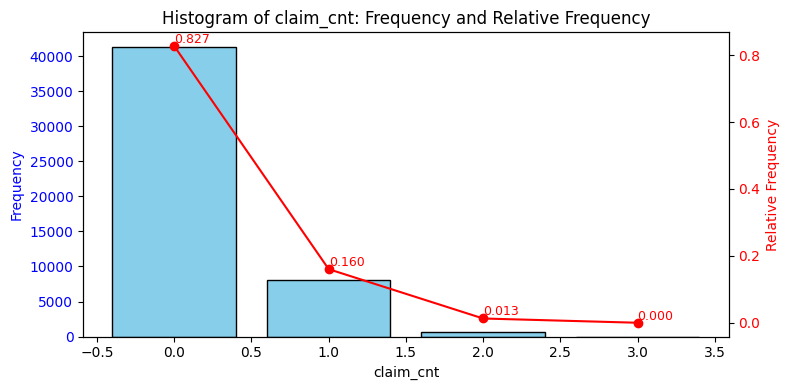

In [5]:
# Plot a histogram of 'claim_cnt' showing both frequency and relative frequency, with annotations
import matplotlib.pyplot as plt
import numpy as np

# Print the mean and variance of the claim_cnt column
mean_claim_cnt = model_data['claim_cnt'].mean()
var_claim_cnt = model_data['claim_cnt'].var()
print(f"Mean of claim_cnt: {mean_claim_cnt:.3f}")
print(f"Variance of claim_cnt: {var_claim_cnt:.3f}")

# Show the claim count distribution
counts, bins = np.histogram(model_data['claim_cnt'], bins=range(int(model_data['claim_cnt'].min()), int(model_data['claim_cnt'].max())+2))
rel_freq = counts / counts.sum()

fig, ax1 = plt.subplots(figsize=(8,4))

# Frequency histogram
ax1.bar(bins[:-1], counts, width=0.8, color='skyblue', edgecolor='black', label='Frequency')
ax1.set_xlabel('claim_cnt')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Relative frequency (secondary axis)
ax2 = ax1.twinx()
ax2.plot(bins[:-1], rel_freq, 'o-', color='red', label='Relative Frequency')
ax2.set_ylabel('Relative Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Annotate relative frequency values next to red dots
for x, y in zip(bins[:-1], rel_freq):
    ax2.text(x, y, f'{y:.3f}', color='red', fontsize=9, ha='left', va='bottom')

plt.title('Histogram of claim_cnt: Frequency and Relative Frequency')
fig.tight_layout()
plt.show()

#### Visualize claim severity

Gamma Distribution: Kurtosis and Mean-Variance Relationship
- **Kurtosis**: The excess kurtosis of a Gamma distribution with shape parameter $k$ is $6/k$. The total kurtosis is $6/k + 3$.
- **Mean and Variance**: For shape $k$ and scale $\theta$:
    - Mean: $\mu = k\theta$
    - Variance: $\sigma^2 = k\theta^2$
    - So, $\text{Variance} = \text{Mean} \times \theta$

Mean of claim_sev: 2559.811
Variance of claim_sev: 3187854.385
Skewness of claim_sev: 0.549
Kurtosis of claim_sev: -0.104


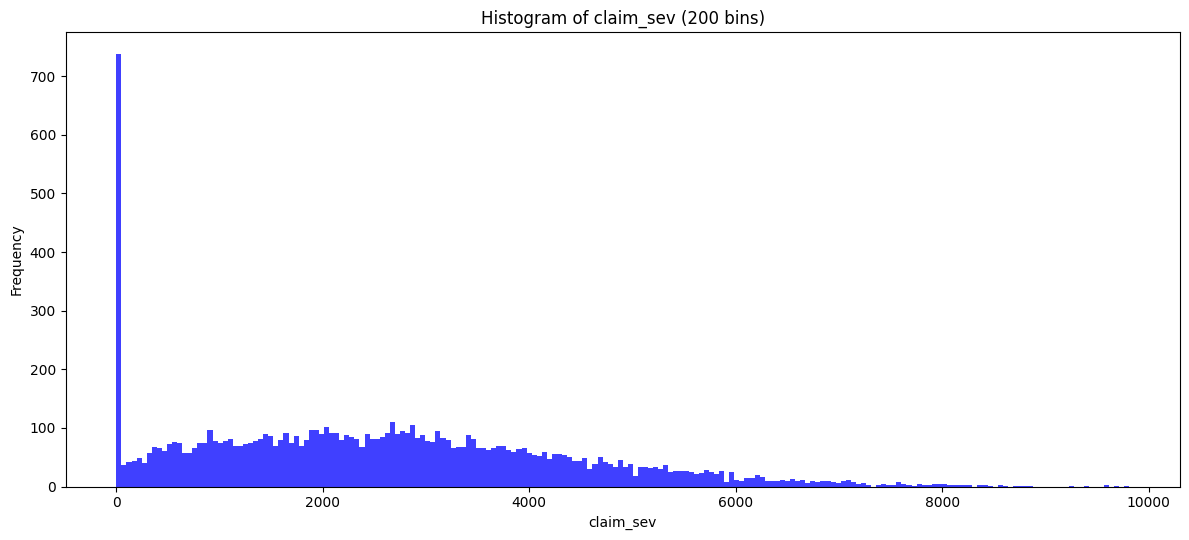

In [6]:
# Compute mean, variance, skewness, and kurtosis of claim_sev
mean_sev = model_data['claim_sev'].dropna().mean()
var_sev = model_data['claim_sev'].dropna().var()
skew_sev = model_data['claim_sev'].dropna().skew()
kurt_sev = model_data['claim_sev'].dropna().kurtosis()
print(f"Mean of claim_sev: {mean_sev:.3f}")
print(f"Variance of claim_sev: {var_sev:.3f}")
print(f"Skewness of claim_sev: {skew_sev:.3f}")
print(f"Kurtosis of claim_sev: {kurt_sev:.3f}")

# Plot a histogram of 'claim_sev' with 100 bins
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5.5))
plt.hist(model_data['claim_sev'].dropna(), bins=200, facecolor='blue', alpha=0.75)
plt.xlabel('claim_sev')
plt.ylabel('Frequency')
plt.title('Histogram of claim_sev (200 bins)')
plt.tight_layout()
plt.show()

Cap severity variable

In [7]:
# QQ plot for claim_sev before and after capping at a specified percentile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.pylab import rcParams

# Set capping percentile and calculate cap value
cap_percentile = 99.5
cap_value = 1000 * round(np.nanpercentile(model_data['claim_sev'], cap_percentile) / 1000, 0)

# Cap the claim_sev variable
model_data['claim_sev_capped'] = model_data['claim_sev'].clip(upper=cap_value)

# Calculate share of capped to original
share_incurred = model_data['claim_sev_capped'].sum() / model_data['claim_sev'].sum()

# Print kurtosis and share information
print(f"Kurtosis of original claim_sev: {stats.kurtosis(model_data['claim_sev'].dropna()):.3f}")
print(f"Kurtosis of capped claim_sev: {stats.kurtosis(model_data['claim_sev_capped'].dropna()):.3f}")
print(f"After capping at the {cap_percentile} percentile (cap value: {cap_value}), the % of total capped claim_sev to the total original claim_sev is {100 * share_incurred:.1f}%.")

# Prepare data for QQ plots
y_ori = model_data['claim_sev'].dropna()
y_capped = model_data.loc[model_data['claim_sev']<=cap_value, 'claim_sev_capped'].dropna()

# Fit gamma distributions
sparams_ori = stats.gamma.fit(y_ori, floc=0)
sparams_capped = stats.gamma.fit(y_capped, floc=0)

# Plot QQ plots
rcParams['figure.figsize'] = 12, 5.5
fig, (ax1, ax2) = plt.subplots(1, 2)
stats.probplot(y_ori, sparams_ori, dist='gamma', plot=ax1)
ax1.set_title('Original claim_sev')
stats.probplot(y_capped, sparams_capped, dist='gamma', plot=ax2)
ax2.set_title('Capped claim_sev')
plt.tight_layout()
plt.show()

# Plot a histogram of 'claim_sev' and 'claim_sev_capped' with 200 bins
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12, 5.5
plt.hist(model_data['claim_sev'].dropna(), bins=200, range=[0, 60000], facecolor='blue', alpha=0.5, label='Original')
plt.hist(model_data['claim_sev_capped'].dropna(), bins=200, range=[0, 60000], facecolor='orange', alpha=0.5, label='Capped')
plt.xlabel('claim_sev')
plt.ylabel('Frequency')
plt.ylim([0,500])
plt.title('Histogram of claim_sev (200 bins)')
plt.tight_layout()
plt.show()

Kurtosis of original claim_sev: -0.105
Kurtosis of capped claim_sev: -0.237
After capping at the 99.5 percentile (cap value: 8000.0), the % of total capped claim_sev to the total original claim_sev is 99.9%.


FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'gamma' requires that 0 < (x - loc)/scale  < inf for each x in `data`.

#### Compute total claim amount

In [8]:
# Compute the capped claim amount
model_data['claim_amt_capped'] = model_data.apply(
    lambda row: row['claim_cnt'] * row['claim_sev_capped'] if row['claim_cnt']!=0 else 0, 
    axis=1
)

# Print the total original and capped claim amounts
print(f"Average original claim amount: {model_data['claim_amt'].mean():.3f}")
print(f"Average capped claim amount: {model_data['claim_amt_capped'].mean():.3f}")
# Print the combined original and capped loss ratios
print(f"Combined original loss ratio: {model_data['claim_amt'].sum() / model_data['annual_premium'].sum():.3f}")
print(f"Combined capped loss ratio: {model_data['claim_amt_capped'].sum() / model_data['annual_premium'].sum():.3f}")

Average original claim amount: 489.541
Average capped claim amount: 489.180
Combined original loss ratio: 0.683
Combined capped loss ratio: 0.683


## Split Data

In [9]:
# Add a 'fold' column with random assignment of 1,2,3,4 to each row, using a fixed random seed
np.random.seed(42)  # Fix the random seed for reproducibility
model_data['fold'] = np.random.choice([1, 2, 3, 4], size=len(model_data))
rich.print(model_data['fold'].value_counts())

# Create a 'sample' column based on the 'fold' column
model_data['sample'] = np.where(model_data['fold'].isin([1,2,3]), '1|bld', '2|val')
rich.print(model_data['sample'].value_counts())

fold
1    12616
4    12522
2    12432
3    12430
Name: count, dtype: int64

sample
1|bld    37478
2|val    12522
Name: count, dtype: int64

### Load Data Into Memory

In [10]:
output_folder = "../.local/analysis_pipeline/data_exploration"
os.makedirs(output_folder, exist_ok=True)
model_data.to_parquet(f"{output_folder}/model_data_09162025.parquet", index=False)
inference_data.to_parquet(f"{output_folder}/inference_data_09162025.parquet", index=False)

## Consistency Check
### Create a combined data set for consistency check purpose

In [11]:
# Create predictor list
pred_lst = ['agecat2', 'gender', 'credit_score', 'area', 'traffic_index', 'veh_age', 'veh_body', 'veh_value']
cols = ['pol_year', 'veh_cnt'] + pred_lst

# Concatenate model_data[cols] and inference_data[cols] vertically
combined_expo_pred_data = pd.concat(
    [model_data[cols], 
     inference_data[cols]], 
     axis=0, 
     ignore_index=True
     )
print('Combined data shape:', combined_expo_pred_data.shape)
combined_expo_pred_data.head()

Combined data shape: (55000, 10)


,pol_year,veh_cnt,agecat2,gender,credit_score,area,traffic_index,veh_age,veh_body,veh_value
0,2017,1,NaN,M,566.644937,A,72.104017,2.557480,SEDAN,2.289678
1,2017,1,NaN,F,691.515821,C,107.602505,2.792034,SEDAN,1.826403
2,2017,1,NaN,M,614.973556,A,80.482879,2.452349,STNWG,2.899493
3,2017,1,NaN,M,614.002052,A,85.560472,2.462938,STNWG,2.702998
4,2017,1,NaN,M,682.434840,A,67.920249,2.644569,SEDAN,2.287953



--- Consistency Plot for agecat2 ---


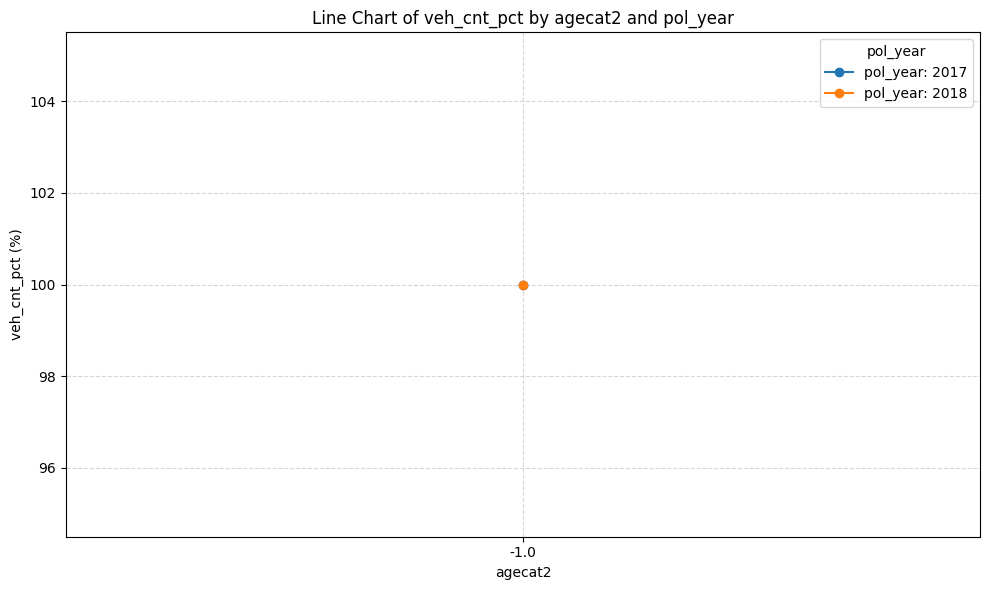


--- Consistency Plot for gender ---


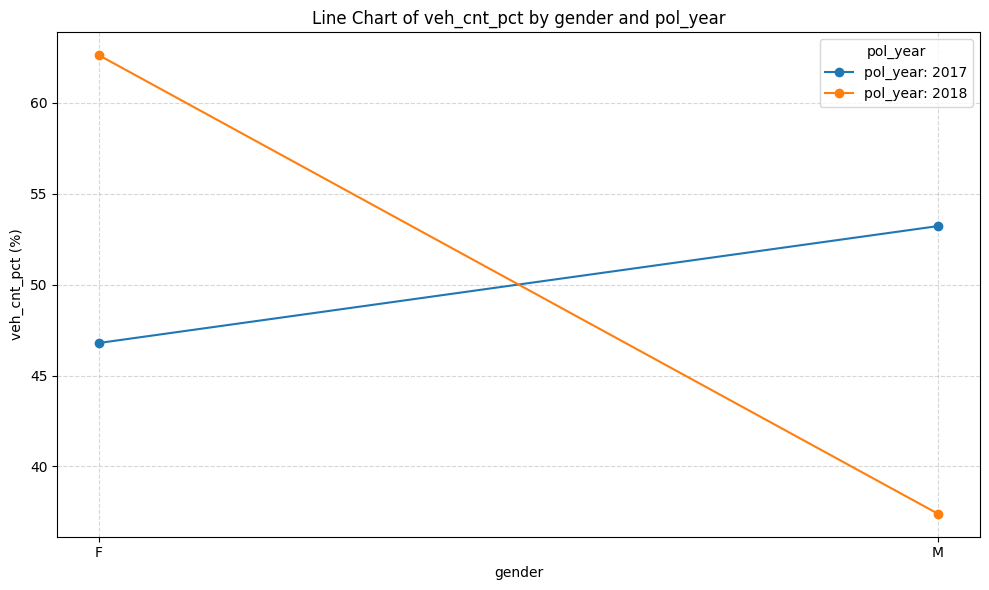


--- Consistency Plot for credit_score ---


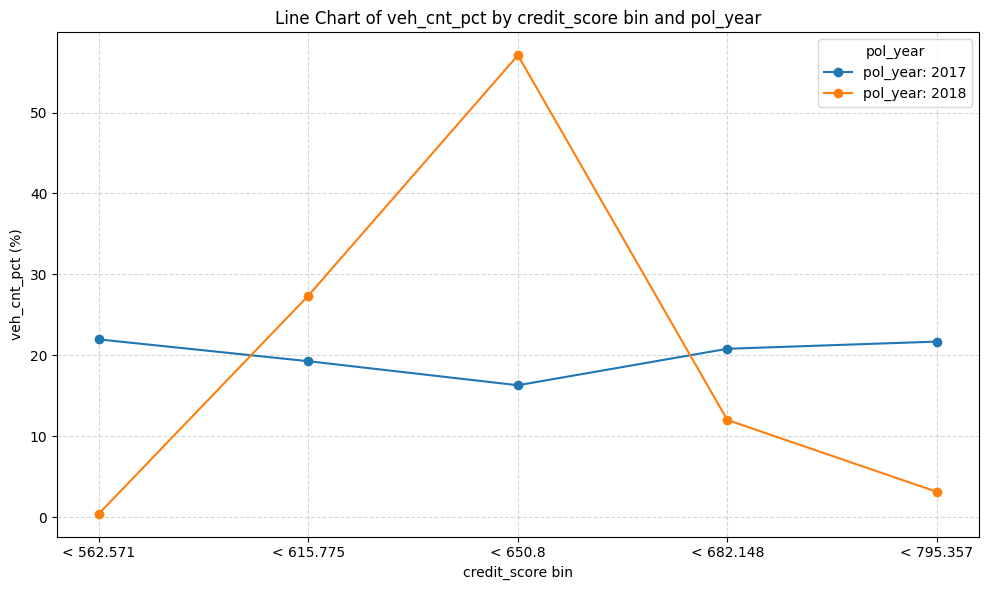


--- Consistency Plot for area ---


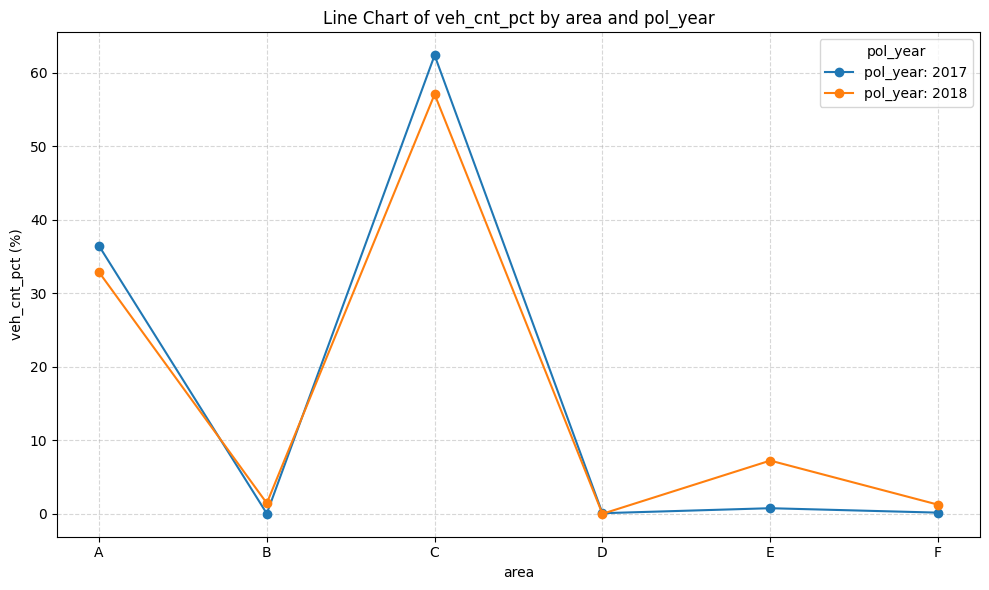


--- Consistency Plot for traffic_index ---


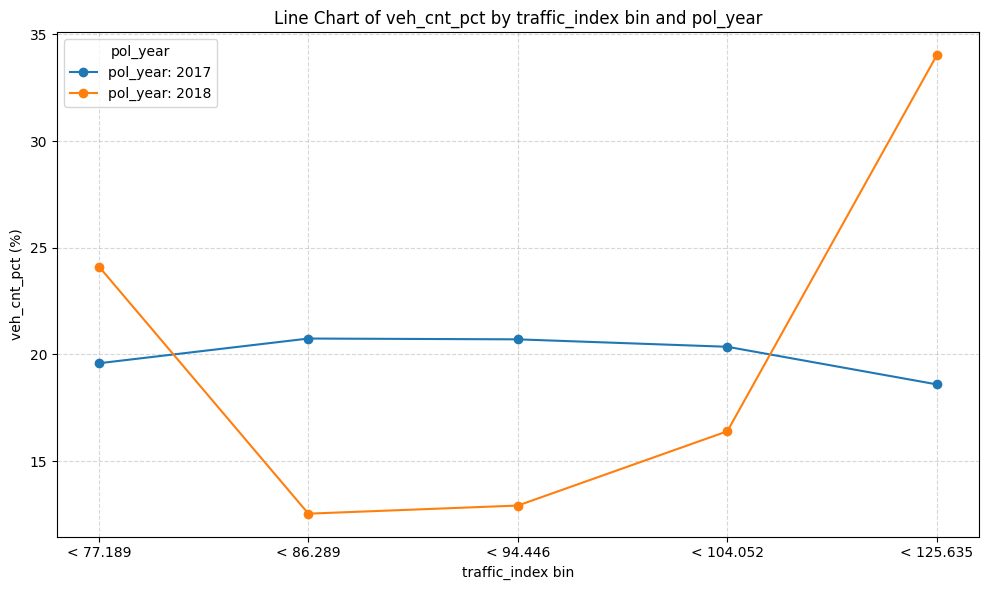


--- Consistency Plot for veh_age ---


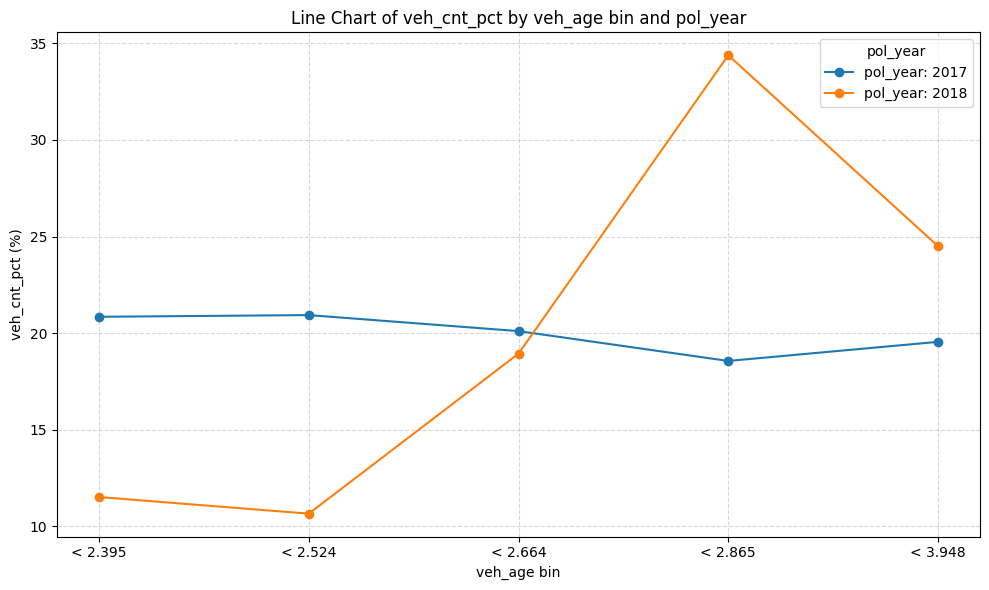


--- Consistency Plot for veh_body ---


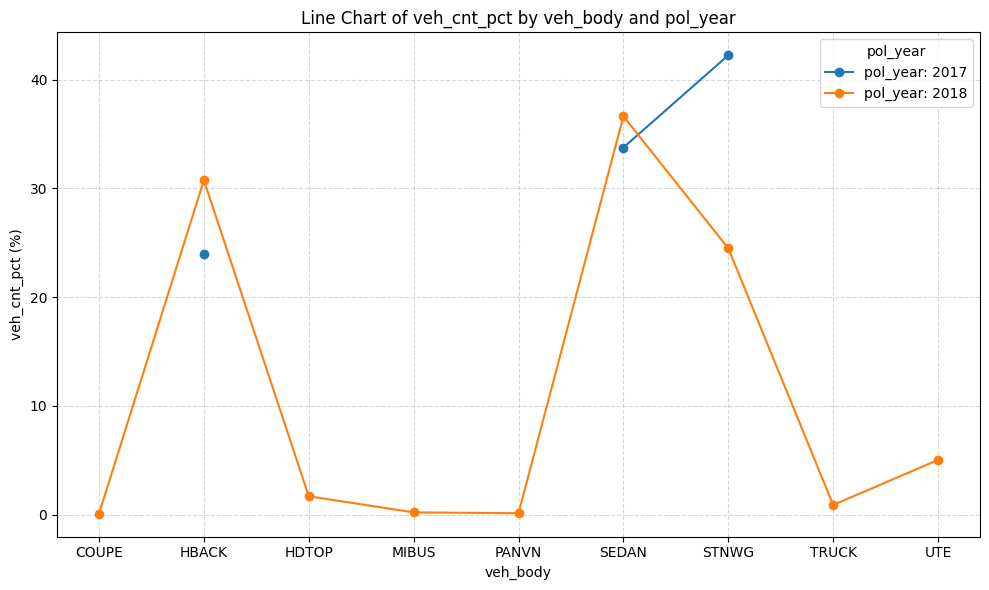


--- Consistency Plot for veh_value ---


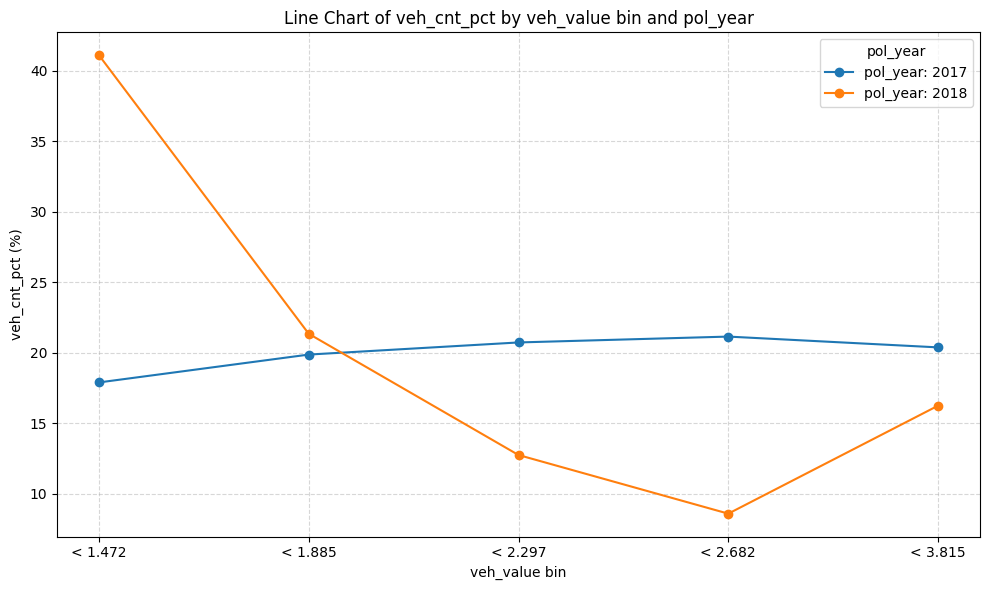

In [12]:
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import ConsistencyCheckList

ccl = ConsistencyCheckList(
    data=combined_expo_pred_data, 
    pred_var_lst=pred_lst, 
    expo_var='veh_cnt', 
    year_var='pol_year')
ccl.run_all()
ccl.plot_all()

### Consistency check illustration with multiple years of data
<div style="background-color: #f8f8f8; padding: 10px;">
    <img src="../images/2_stability_chart.png" alt="Transformation Illustration" style="max-width:50%;">
</div>

## Predictiveness Check


--- Predictiveness Plot for agecat2 ---


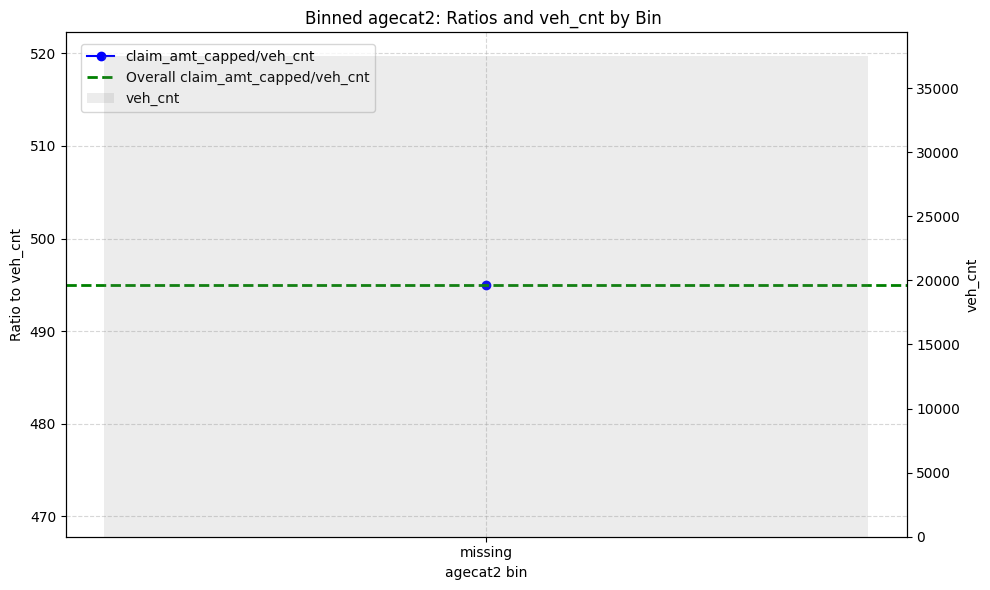


--- Predictiveness Plot for gender ---


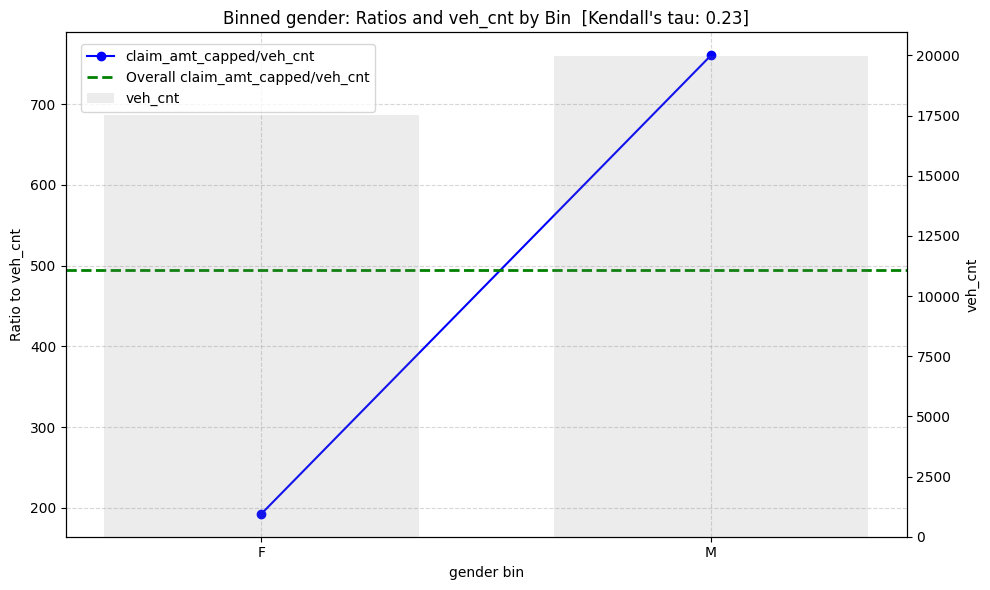


--- Predictiveness Plot for credit_score ---


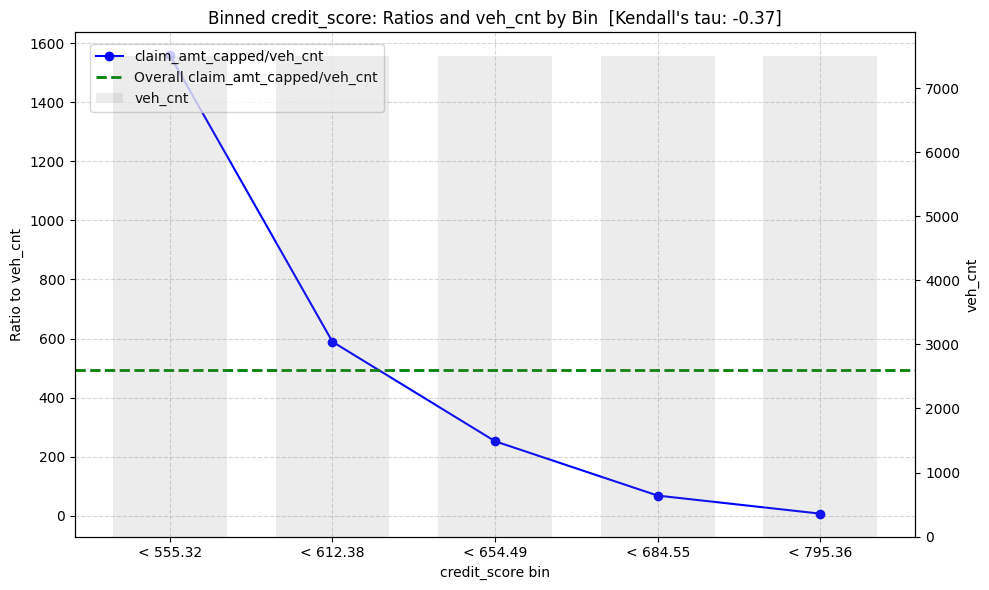


--- Predictiveness Plot for area ---


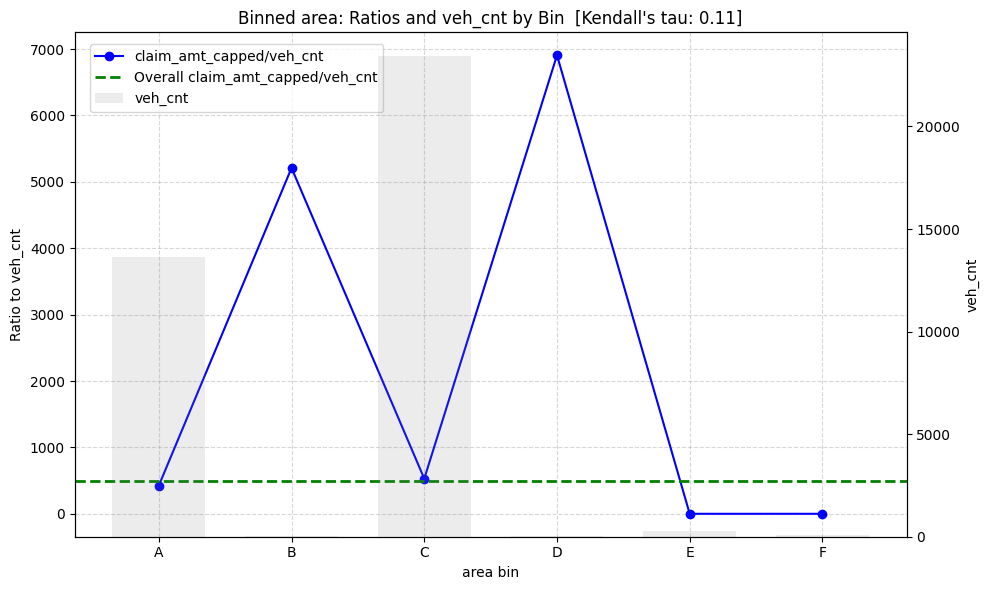


--- Predictiveness Plot for traffic_index ---


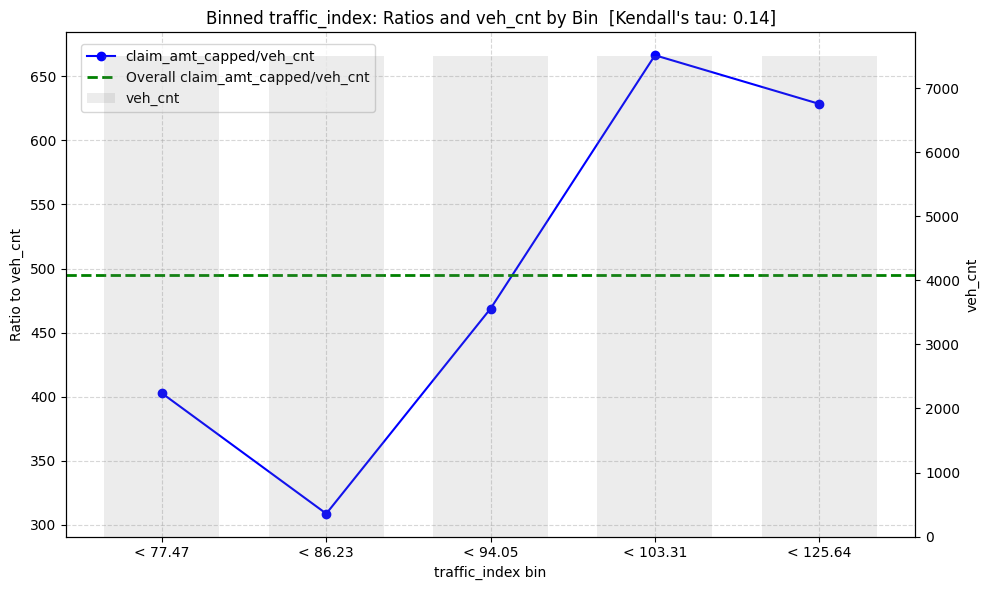


--- Predictiveness Plot for veh_age ---


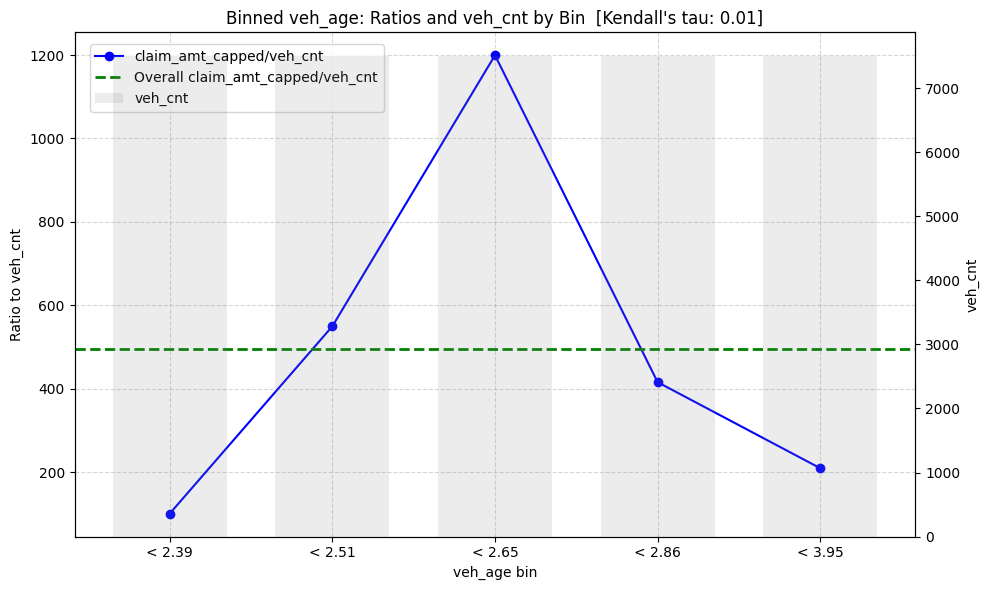


--- Predictiveness Plot for veh_body ---


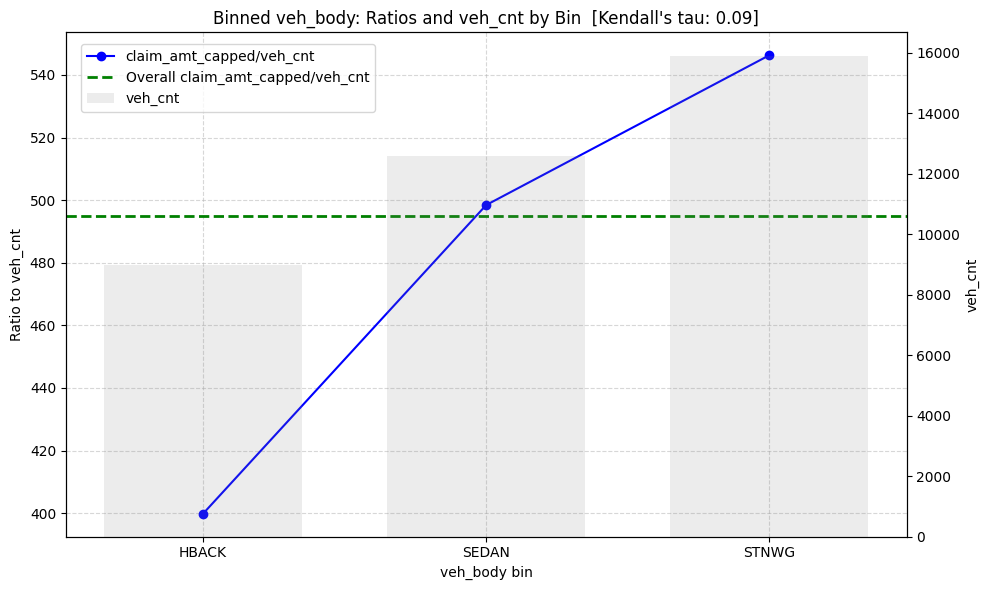


--- Predictiveness Plot for veh_value ---


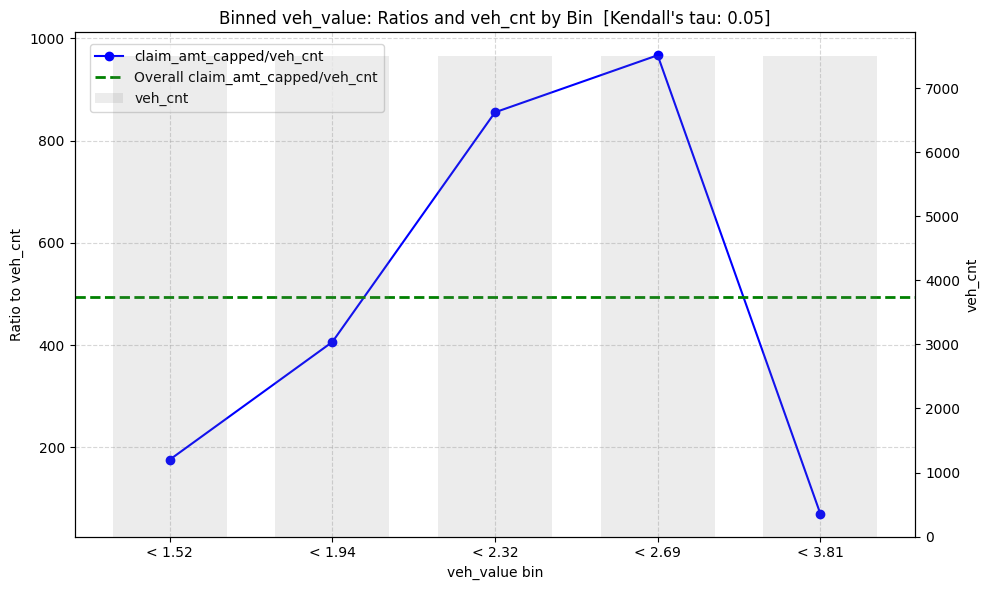

In [13]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
train_data = model_data.loc[model_data['sample'] == '1|bld']  
exp_var = 'veh_cnt' 
var_1 = 'claim_amt_capped'     
var_2 = None   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=train_data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all()

## Varaible Reduction
### Our case - a baby version

In [14]:
# One-hot encode categorical variables in pred_lst
categorical_cols = [col for col in pred_lst if train_data[col].dtype == 'object' or str(train_data[col].dtype).startswith('category')]
train_data_encoded = pd.get_dummies(train_data, columns=categorical_cols, drop_first=False)

# Update pred_lst to include new dummy variable columns
new_pred_lst = []
for col in pred_lst:
    if col in categorical_cols:
        new_pred_lst.extend([c for c in train_data_encoded.columns if c.startswith(col + '_')])
    else:
        new_pred_lst.append(col)

print('Categorical columns one-hot encoded:', categorical_cols)
print('New predictor list:', new_pred_lst)

Categorical columns one-hot encoded: ['gender', 'area', 'veh_body']
New predictor list: ['agecat2', 'gender_F', 'gender_M', 'credit_score', 'area_A', 'area_B', 'area_C', 'area_D', 'area_E', 'area_F', 'traffic_index', 'veh_age', 'veh_body_COUPE', 'veh_body_HBACK', 'veh_body_HDTOP', 'veh_body_MIBUS', 'veh_body_Other', 'veh_body_PANVN', 'veh_body_SEDAN', 'veh_body_STNWG', 'veh_body_TRUCK', 'veh_body_UTE', 'veh_value']


In [15]:
# Create a new DataFrame with 'var_1', all numerical variables in pred_lst and new_pred_lst
# Identify numerical columns in pred_lst and new_pred_lst
num_pred_cols = [col for col in pred_lst if pd.api.types.is_numeric_dtype(train_data[col])]
selected_cols = new_pred_lst + num_pred_cols
train_data_num = train_data_encoded[selected_cols].copy()
print('Columns in new DataFrame:', train_data_num.columns.tolist())
train_data_num.head(5)

Columns in new DataFrame: ['agecat2', 'gender_F', 'gender_M', 'credit_score', 'area_A', 'area_B', 'area_C', 'area_D', 'area_E', 'area_F', 'traffic_index', 'veh_age', 'veh_body_COUPE', 'veh_body_HBACK', 'veh_body_HDTOP', 'veh_body_MIBUS', 'veh_body_Other', 'veh_body_PANVN', 'veh_body_SEDAN', 'veh_body_STNWG', 'veh_body_TRUCK', 'veh_body_UTE', 'veh_value', 'agecat2', 'credit_score', 'traffic_index', 'veh_age', 'veh_value']


,agecat2,gender_F,gender_M,credit_score,area_A,area_B,area_C,area_D,area_E,area_F,...,veh_body_SEDAN,veh_body_STNWG,veh_body_TRUCK,veh_body_UTE,veh_value,agecat2,credit_score,traffic_index,veh_age,veh_value
0,5.0,False,True,631.0,False,True,False,False,False,False,...,False,False,True,False,0.924,5.0,631.0,140.9,4,0.924
2,1.0,False,True,838.0,False,False,False,True,False,False,...,True,False,False,False,1.100,1.0,838.0,88.8,3,1.100
3,2.0,False,True,835.0,False,False,False,False,True,False,...,True,False,False,False,2.090,2.0,835.0,NaN,2,2.090
4,3.0,True,False,748.0,False,False,True,False,False,False,...,False,False,False,False,0.803,3.0,748.0,123.0,3,0.803
6,4.0,False,True,759.0,False,False,False,False,True,False,...,False,True,False,False,1.452,4.0,759.0,75.0,4,1.452


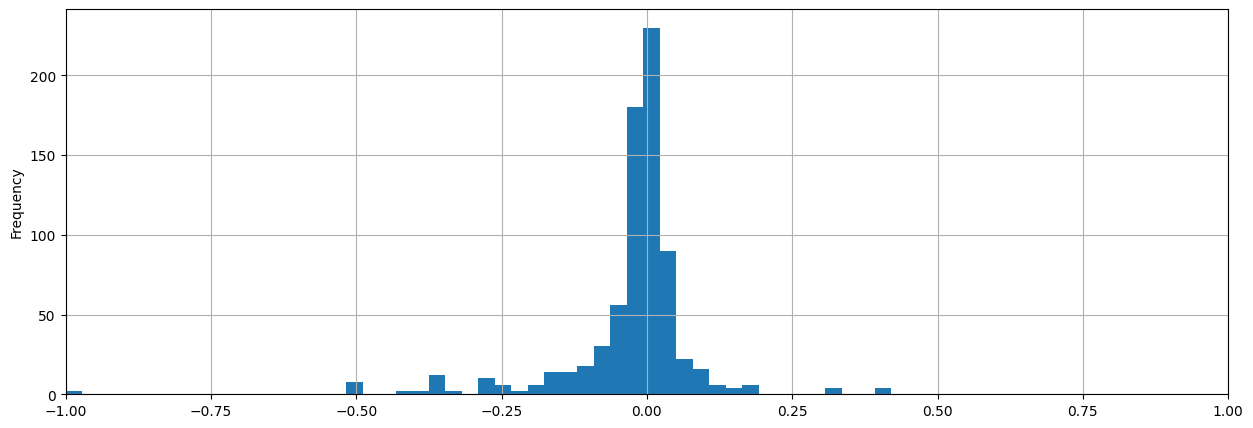

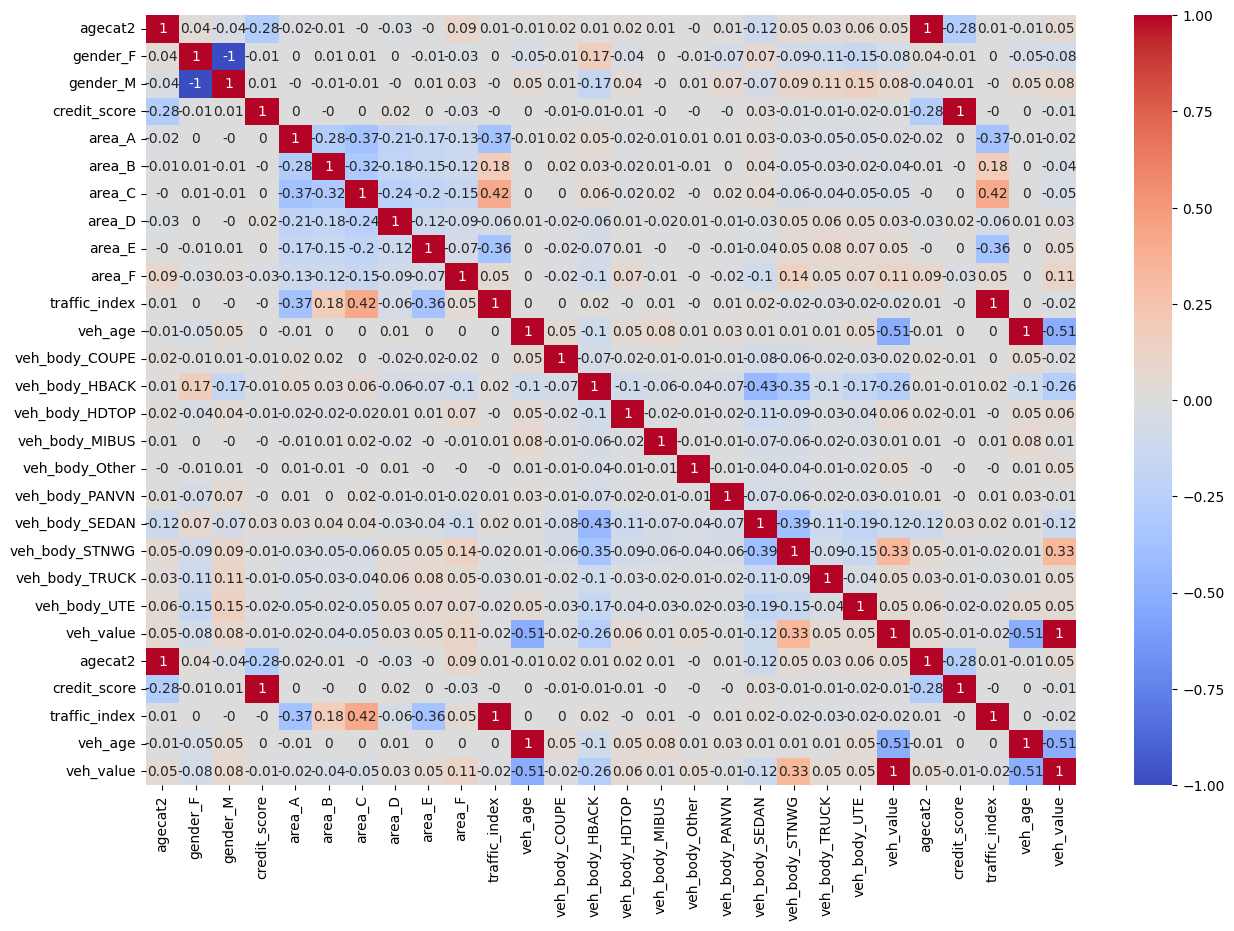

In [25]:
## histogram on the correlation of the predictors
corr_val_df = round(train_data_num.corr(method='kendall'), 2)
corr_val_vec = pd.Series(  [item for sublist in corr_val_df.values.tolist() for item in sublist if item < 1.0] )
rcParams['figure.figsize'] = 15, 4
corr_val_vec.plot.hist( bins = 50, figsize = (15, 5), xlim = (-1, 1), grid = True )
## heatmap on the pairwise correlations among the predictors
import seaborn as sns
plt.subplots( figsize=(15, 10) )
ax = sns.heatmap( corr_val_df, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1 )
plt.show()

## <span style="color:red"><b><i>Variable Reduction on Real World Scenarios</i></b></span>
In real-wordl application, there are usually hundreds of predictors from different data sources. For instance, in the insurance industry, we usually have the following data sources: 
<br>
1. Internal data: 
    - Telematics: Average speed, Mileage and braking habits, ... 
    - Claim history: Historical 5-yr loss ratio, Historical 3-yr number of physical damage claims, ...
    - Policyholder characters: Gender, Age, Income, Marital status ...
2. Motor vehicle record: Number of major violations, Number of minor violations, ...
3. Geographic data (zip code based): Population density, Average commute time, ...
4. Claimate data:  Distance to nearest water body, Average tempature, ...54. Financial credit data: Credit score, Number of late payments, ...
<br>

#### First round variable reduction via a tree-based algorithm
From my experience, one way to conduct variable reduction with massive data is to utilize a tree-based algorithm for the first round of variable reduction screening.
<br>
1. We start from the most promissing data source. Specifically, we build a tree-based model and delete predictors with the lowest variable importances. Usually, we leave 20-40 predictors on a data source.
2. We build a second tree-based model with the selected predictors from the first data source and all predictors from the second most promissing data source. Then, we remove the predictors with the lowest variable importances from the second data source.
3. We repeat step 2 with the 3rd most promissing data source, the 4th data source, ..., until we screen all data sources. 
<br>
In the end of the first round of variable reduction, we result in 100+ predictors for more precise analysis. - <span style="color:red"><b><i> A flowchat might be helpful to illustrate the first round variable reduction. </i></b></span>





#### Second round variable reduction via VarClusHi - A PCA Embedded Methodology
- VarClusHi Documentations:
    - SAS: https://support.sas.com/documentation/onlinedoc/stat/132/varclus.pdf
    - Python: https://github.com/jingtt/varclushi?tab=readme-ov-file
- <span style="color:red"><b><i>Task 1: </i></b></span> 
    1. <span style="color:red"><b><i>Read and summarize the VarClusHi procedure via markdown.</i></b></span>
    2. <span style="color:red"><b><i>Run the procedure on our data to test its functionality.</i></b></span>

- A VarClusHi Illustration

    | Cluster | Variable              | RS_Own   | RS_NC    | RS_Ratio | Importance | Kendall_tau | 
    |---------|-----------------------|----------|----------|----------|------------|-------------|
    | 0       | fixed acidity         | 0.882210 | 0.277256 | 0.162976 |        0.21|         0.15|
    | 0       | density               | 0.622070 | 0.246194 | 0.501362 |        0.12|         0.05|
    | 0       | pH                    | 0.637076 | 0.194359 | 0.450478 |        0.05|         0.03|
    | 1       | free sulfur dioxide   | 0.777796 | 0.010358 | 0.224530 |        0.32|         0.20|
    | 1       | total sulfur dioxide  | 0.786660 | 0.042294 | 0.222761 |        0.21|         0.15|
    | 1       | residual sugar        | 0.202428 | 0.045424 | 0.835525 |        0.17|         0.12|
    | 2       | sulphates             | 0.685630 | 0.106022 | 0.351653 |        0.07|         0.08|
    | 2       | chlorides             | 0.685630 | 0.048903 | 0.330534 |        0.05|         0.09|
    | 3       | citric acid           | 0.776248 | 0.398208 | 0.371810 |        0.41|         0.25|
    | 3       | volatile acidity      | 0.776248 | 0.040920 | 0.233299 |        0.30|         0.15|
    | 4       | alcohol               | 1.000000 | 0.082055 | 0.000000 |        0.18|         0.12|

## Transformation Check - Additional Task for Linear Models
When building a linear model, we perform additional analysis to floor, cap and transform predictors.
<div style="background-color: #f8f8f8; padding: 10px;">
    <img src="../images/3_transformation_plot.png" alt="Transformation Illustration" style="max-width:50%;">
</div>